In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam


2023-12-19 11:48:12.310568: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-19 11:48:12.418408: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-19 11:48:12.418495: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-19 11:48:12.418620: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-19 11:48:12.437568: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-19 11:48:12.438692: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

# Load Data

In [2]:
import os
import numpy as np


def load_data(folder):
    data = []
    labels = []
    for subfolder in os.listdir(folder):
        subfolder_path = os.path.join(folder, subfolder)
        if os.path.isdir(subfolder_path):
            for file in os.listdir(subfolder_path):
                file_path = os.path.join(subfolder_path, file)
                if file.endswith('.npy'):
                    # Load numpy array
                    array = np.load(file_path).flatten()
                    data.append(array)
                    # Label phishing as 1, benign as 0
                    label = 1 if (folder.find('phishing') != -1) else 0
                    labels.append(label)
    return np.array(data), np.array(labels)

# Đường dẫn đến thư mục chứa dữ liệu
phishing_path = 'VisualPhish/phishing_features'
benign_path = 'VisualPhish/trusted_list_features'

# Load dữ liệu
phishing_data, phishing_labels = load_data(phishing_path)
benign_data, benign_labels = load_data(benign_path)



# DCGAN

In [3]:
def build_generator(noise_dim):
    model = tf.keras.Sequential([
        Dense(256, input_shape=(noise_dim,)),
        LeakyReLU(alpha=0.2),
        Dense(512),  # Tăng số lượng neuron
        LeakyReLU(alpha=0.2),
        Dense(1024),  # Tăng thêm số lượng neuron
        LeakyReLU(alpha=0.2),
        Dense(512)  # Output layer với 512 units
    ])
    return model

def build_discriminator():
    model = tf.keras.Sequential([
        Dense(1024, input_shape=(512,)),
        LeakyReLU(alpha=0.2),
        Dense(512),  # Giảm số lượng neuron
        LeakyReLU(alpha=0.2),
        Dense(256),  # Giảm thêm số lượng neuron
        LeakyReLU(alpha=0.2),
        Dense(1, activation='sigmoid')  # Output layer
    ])
    return model

In [4]:
def build_gan(generator, discriminator):
    model = Sequential()

    model.add(generator)
    model.add(discriminator)

    return model

z_dim = 100
batch_size = 32
learning_rate = 0.0002

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate), metrics=['accuracy'])

generator = build_generator(z_dim)

discriminator.trainable = False
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate))


In [5]:
generator.summary()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               25856     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 1024)              525312    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 512)              

In [6]:
def train_gan(gan, generator, discriminator, dataset, z_dim, epochs=100):
    for epoch in range(epochs):
        for real_images in dataset:
            # Điều chỉnh kích thước của z dựa trên kích thước thực tế của real_images
            current_batch_size = real_images.shape[0]
            z = np.random.normal(0, 1, (current_batch_size, z_dim))
            fake_images = generator.predict(z, verbose=0)

            combined_images = np.concatenate([real_images, fake_images])
            labels = np.concatenate([np.ones((current_batch_size, 1)), np.zeros((current_batch_size, 1))])
            labels += 0.05 * np.random.random(labels.shape)

            d_loss = discriminator.train_on_batch(combined_images, labels)

            z = np.random.normal(0, 1, (current_batch_size, z_dim))
            fake_labels = np.ones((current_batch_size, 1))

            g_loss = gan.train_on_batch(z, fake_labels)

        print(f"Epoch: {epoch + 1}, D Loss: {d_loss[0]}, G Loss: {g_loss}")

# Chia dataset thành các batch
dataset = [phishing_data[i:i + batch_size] for i in range(0, len(phishing_data), batch_size)]
if len(dataset[-1]) != batch_size:
    dataset.pop()  # Xóa batch cuối nếu kích thước không phù hợp

# Khởi tạo và huấn luyện mô hình GAN
#train_gan(gan, generator, discriminator, dataset, z_dim, 1000)

# Tái tạo kiến trúc mô hình
generator = build_generator(z_dim)
discriminator = build_discriminator()

# Tải trọng số
generator.load_weights('generator_weights_gan.h5')
discriminator.load_weights('discriminator_weights_gan.h5')
"""

generator.save_weights('generator_weights_gan.h5')
discriminator.save_weights('discriminator_weights_gan.h5')


"""

"\n\ngenerator.save_weights('generator_weights_gan.h5')\ndiscriminator.save_weights('discriminator_weights_gan.h5')\n\n\n"

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def showFeature(features):
  image = features.reshape(16, 32)
  #print(image.shape)
  #print(image)
  
  plt.subplot(1, 1, 1)  # Tạo subplot
  plt.imshow(image, cmap='viridis')  # Sử dụng viridis làm bảng màu
  plt.title(f'Feature map')
  plt.axis('off')  # Ẩn trục tọa độ

  plt.show()

================ 0 =================
Fake:


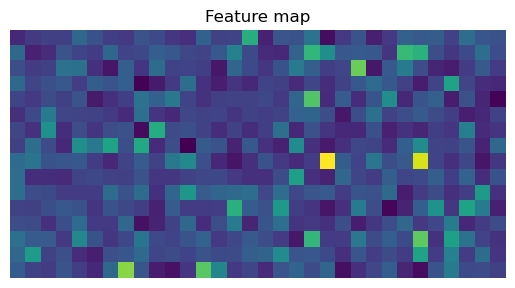

Real:


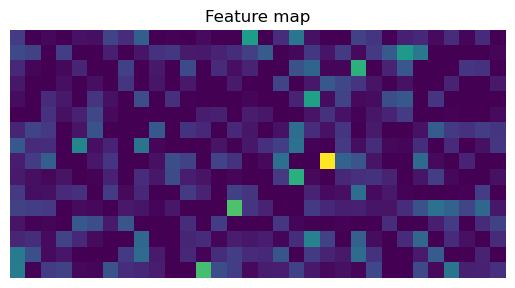

================ 1 =================
Fake:


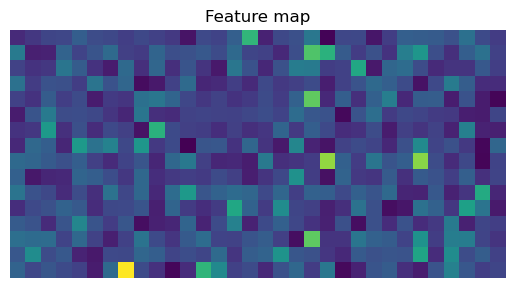

Real:


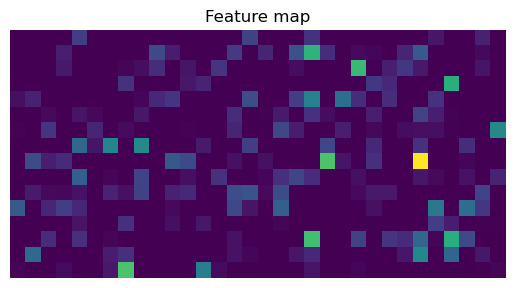

================ 2 =================
Fake:


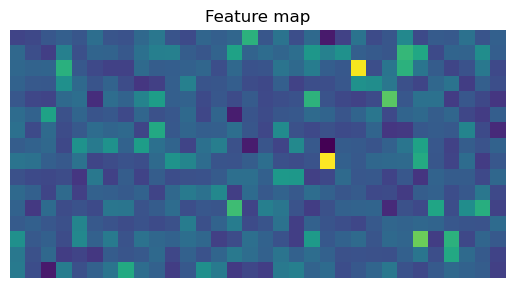

Real:


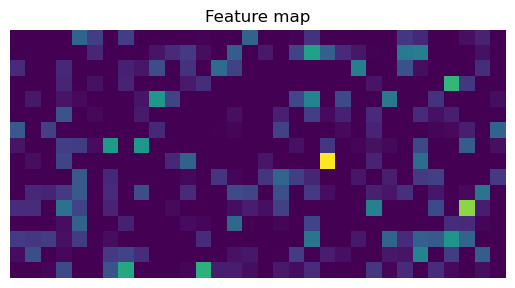

================ 3 =================
Fake:


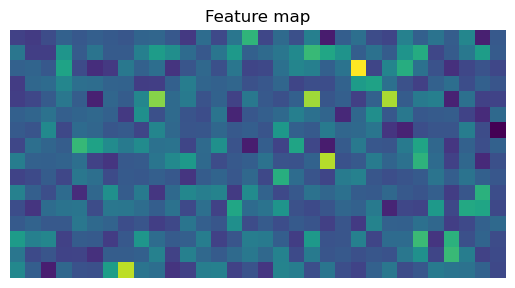

Real:


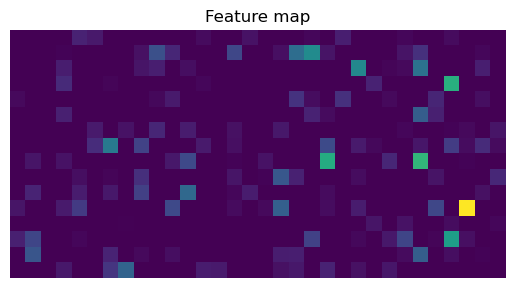

================ 4 =================
Fake:


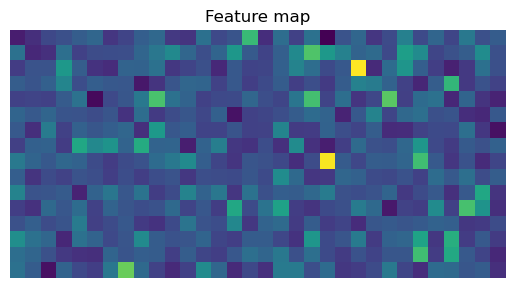

Real:


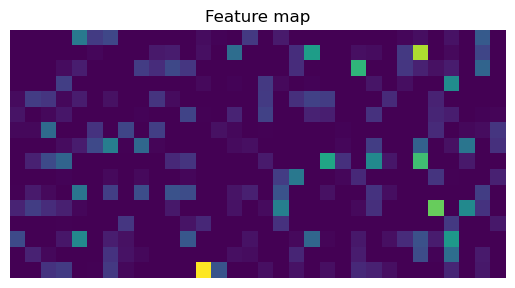

================ 5 =================
Fake:


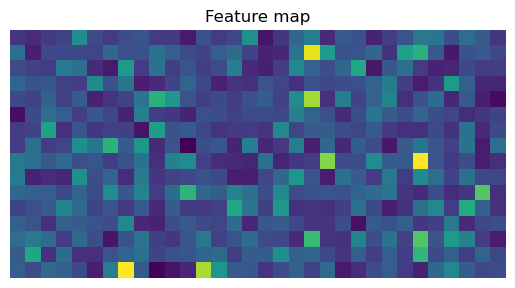

Real:


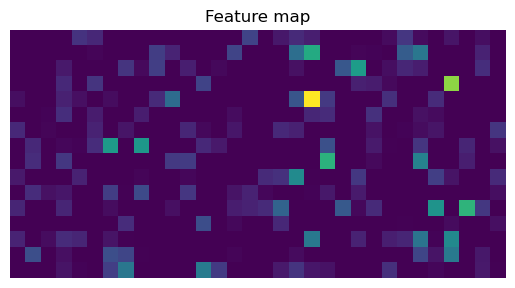

================ 6 =================
Fake:


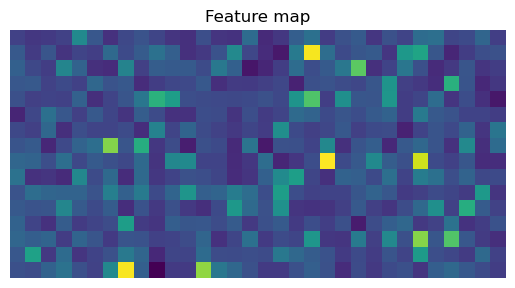

Real:


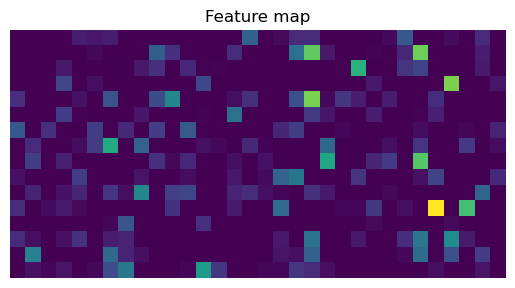

================ 7 =================
Fake:


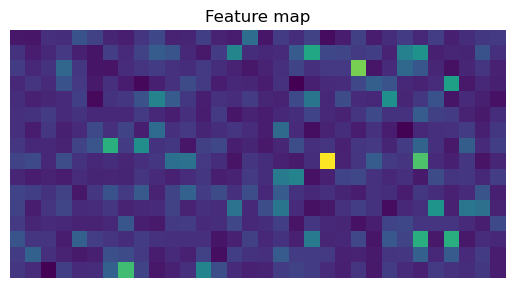

Real:


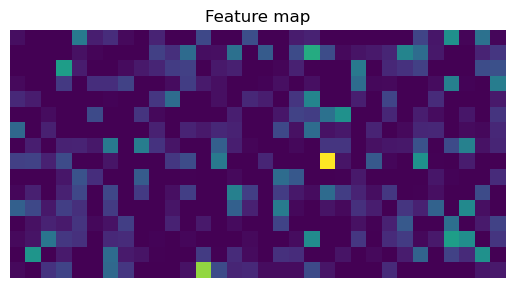

================ 8 =================
Fake:


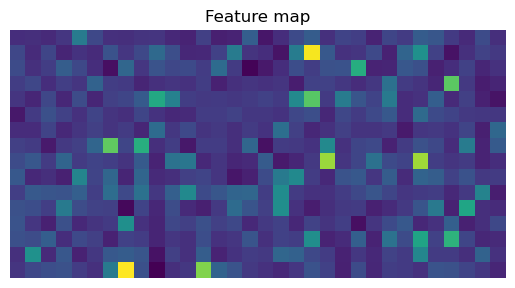

Real:


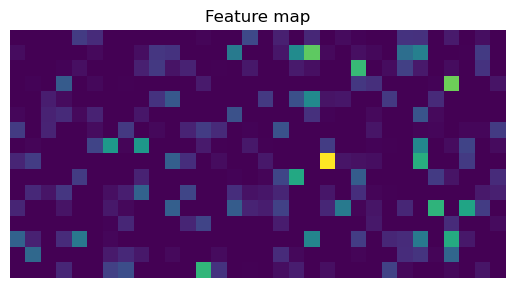

================ 9 =================
Fake:


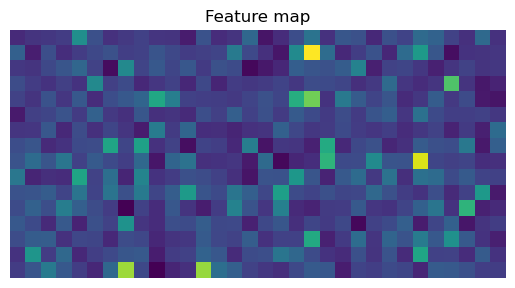

Real:


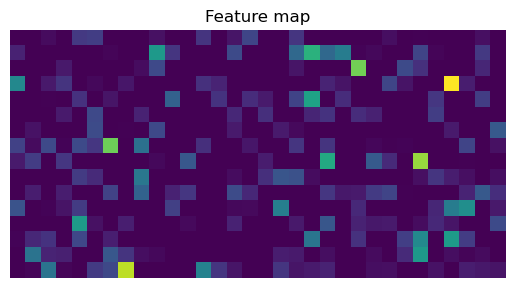

In [8]:
z = np.random.normal(0, 1, (10, z_dim))
fake_images = generator.predict(z, verbose=0)
for i in range(10):
  print("================", i, "=================")
  print("Fake:")
  showFeature(fake_images[i])
  print("Real:")
  showFeature(dataset[0][i])

In [9]:
"""
@tf.function
def train_step(images, z_dim, discriminator, generator, discriminator_optimizer, generator_optimizer):
    # Tạo nhiễu ngẫu nhiên
    noise = tf.random.normal([batch_size, z_dim])

    # GradientTape cho discriminator
    with tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # GradientTape cho generator
    with tf.GradientTape() as gen_tape:
        generated_images = generator(noise, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    """


'\n@tf.function\ndef train_step(images, z_dim, discriminator, generator, discriminator_optimizer, generator_optimizer):\n    # Tạo nhiễu ngẫu nhiên\n    noise = tf.random.normal([batch_size, z_dim])\n\n    # GradientTape cho discriminator\n    with tf.GradientTape() as disc_tape:\n        generated_images = generator(noise, training=True)\n\n        real_output = discriminator(images, training=True)\n        fake_output = discriminator(generated_images, training=True)\n\n        disc_loss = discriminator_loss(real_output, fake_output)\n\n    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)\n    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))\n\n    # GradientTape cho generator\n    with tf.GradientTape() as gen_tape:\n        generated_images = generator(noise, training=True)\n        fake_output = discriminator(generated_images, training=True)\n        gen_loss = generator_loss(fak

In [10]:
print(benign_data.shape)
print(phishing_data.shape)

(9363, 512)
(1195, 512)


In [11]:
while (len(phishing_data) < len(benign_data)):
  print(len(phishing_data), "/", len(benign_data))
  z = np.random.normal(0, 1, (1, z_dim))
  gen_img = generator.predict(z, verbose=0)

  phishing_data = np.vstack((phishing_data, gen_img[0]))
  phishing_labels = np.append(phishing_labels, 1)

print(phishing_data.shape)
print(benign_data.shape)
# Gộp dữ liệu và labels
X = np.concatenate((phishing_data, benign_data), axis=0)
y = np.concatenate((phishing_labels, benign_labels), axis=0)

1195 / 9363


1196 / 9363
1197 / 9363
1198 / 9363
1199 / 9363
1200 / 9363
1201 / 9363
1202 / 9363
1203 / 9363
1204 / 9363
1205 / 9363
1206 / 9363
1207 / 9363
1208 / 9363
1209 / 9363
1210 / 9363
1211 / 9363
1212 / 9363
1213 / 9363
1214 / 9363
1215 / 9363
1216 / 9363
1217 / 9363
1218 / 9363
1219 / 9363
1220 / 9363
1221 / 9363
1222 / 9363
1223 / 9363
1224 / 9363
1225 / 9363
1226 / 9363
1227 / 9363
1228 / 9363
1229 / 9363
1230 / 9363
1231 / 9363
1232 / 9363
1233 / 9363
1234 / 9363
1235 / 9363
1236 / 9363
1237 / 9363
1238 / 9363
1239 / 9363
1240 / 9363
1241 / 9363
1242 / 9363
1243 / 9363
1244 / 9363
1245 / 9363
1246 / 9363
1247 / 9363
1248 / 9363
1249 / 9363
1250 / 9363
1251 / 9363
1252 / 9363
1253 / 9363
1254 / 9363
1255 / 9363
1256 / 9363
1257 / 9363
1258 / 9363
1259 / 9363
1260 / 9363
1261 / 9363
1262 / 9363
1263 / 9363
1264 / 9363
1265 / 9363
1266 / 9363
1267 / 9363
1268 / 9363
1269 / 9363
1270 / 9363
1271 / 9363
1272 / 9363
1273 / 9363
1274 / 9363
1275 / 9363
1276 / 9363
1277 / 9363
1278 / 9363
1279

# DNN

In [12]:

model = Sequential([
    Dense(1024, activation='relu', input_shape=(512,)),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [13]:
from sklearn.model_selection import train_test_split

# Phân chia dữ liệu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=10, batch_size=32)


Epoch 1/10
469/469 [==============================] - 14s 26ms/step - loss: 0.3050 - accuracy: 0.9215
Epoch 2/10
469/469 [==============================] - 12s 25ms/step - loss: 0.1467 - accuracy: 0.9441
Epoch 3/10
469/469 [==============================] - 12s 25ms/step - loss: 0.1381 - accuracy: 0.9499
Epoch 4/10
469/469 [==============================] - 12s 26ms/step - loss: 0.1184 - accuracy: 0.9571
Epoch 5/10
469/469 [==============================] - 12s 26ms/step - loss: 0.0992 - accuracy: 0.9642
Epoch 6/10
469/469 [==============================] - 12s 26ms/step - loss: 0.0879 - accuracy: 0.9669
Epoch 7/10
469/469 [==============================] - 12s 25ms/step - loss: 0.0907 - accuracy: 0.9669
Epoch 8/10
469/469 [==============================] - 12s 25ms/step - loss: 0.0694 - accuracy: 0.9768
Epoch 9/10
469/469 [==============================] - 12s 26ms/step - loss: 0.0604 - accuracy: 0.9782
Epoch 10/10
469/469 [==============================] - 12s 25ms/step - loss: 0.048

In [14]:
# Đánh giá hiệu suất
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy: {accuracy*100:.2f}%")


118/118 [==============================] - 1s 8ms/step - loss: 0.1797 - accuracy: 0.9562
Accuracy: 95.62%


In [15]:
print(len(X_train))
print(len(X_test))

14980
3746


In [16]:
cnt1Train = 0
cnt0Train = 0
for y in y_train:
  if y == 1:
    cnt1Train+=1
  else:
    cnt0Train+=1

print(cnt1Train)
print(cnt1Train / len(y_train))
print(cnt0Train)
print(cnt0Train / len(y_train))


7488
0.4998664886515354
7492
0.5001335113484646


In [17]:
cnt1Test = 0
cnt0Test = 0
for y in y_test:
  if y == 1:
    cnt1Test+=1
  else:
    cnt0Test+=1

print(cnt1Test)
print(cnt1Test / len(y_test))
print(cnt0Test)
print(cnt0Test / len(y_test))


1875
0.500533902829685
1871
0.499466097170315


In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test)
y_pred = [1 if y > 0.5 else 0 for y in y_pred]  # Chuyển đổi xác suất thành nhãn dự đoán

# Tính toán các chỉ số đánh giá
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"AUC: {auc:.2f}")


118/118 [==============================] - 1s 8ms/step
Accuracy: 95.62%
Precision: 0.98
Recall: 0.93
F1-Score: 0.96
AUC: 0.96


In [19]:
print(y_pred)

[0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 